# Dpi Setting

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


### Dependencies

### Python

In [5]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [6]:
!apt-get install -y r-base
!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [7]:
from rpy2.robjects.packages import importr


In [8]:
%load_ext rpy2.ipython

### R

In [9]:
%%R

#library(spcosa)
#ibrary(spsurvey)
if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

Loading required package: WaveSampling
Loading required package: Matrix
Loading required package: sampling
Loading required package: BalancedSampling
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/local/lib/R/site-library’ contains no packages


### Imports

In [10]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

/home/divar/projects/geometric-sampling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Simulations

### Methods

In [14]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

# sb_value <- tryCatch({
#   sb(probs, coords, sample_idx)  # Spatial balance
# }, error = function(e) {
#   Inf
# })

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    #SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[0][0], IB_value, SBLB_value


In [17]:
import os
import pandas as pd
import numpy as np
import time

# from your_module import scores

SAMPLES_FOLDER = '/home/divar/projects/geometric-sampling/data_samples/samples/'
RESULTS_FOLDER = '/home/divar/projects/geometric-sampling/data_samples/results/'
COORDS_PROBS_FOLDER = '/home/divar/projects/geometric-sampling/data_samples/coords_probs/'

def get_coords_probs_name(sample_filename):
    base = "_".join(sample_filename.split('_')[:2])
    fname = f'{base}.csv'
    return fname

def get_scenario_basename(sample_filename):
    return "_".join(sample_filename.split('_')[:2])

def get_method(sample_filename):
    return sample_filename.split('_')[2]

file_list = [f for f in os.listdir(SAMPLES_FOLDER) if f.endswith('.csv')]

total_files = len(file_list)
all_total_samples = 0
samples_per_file = {}

# Count total number of samples for all files (to estimate global progress)
for f in file_list:
    sample_path = os.path.join(SAMPLES_FOLDER, f)
    samples_df = pd.read_csv(sample_path)
    samples_per_file[f] = len(samples_df)
    all_total_samples += len(samples_df)

print(f"Processing {len(file_list)} sample files with {all_total_samples} total samples...")

sample_counter = 0
t0 = time.time()  # Start time for total process

for file_idx, sample_file in enumerate(file_list):
    sample_path = os.path.join(SAMPLES_FOLDER, sample_file)
    samples_df = pd.read_csv(sample_path)
    scenario_basename = get_scenario_basename(sample_file)
    method = get_method(sample_file)

    coords_probs_fname = get_coords_probs_name(sample_file)
    coords_probs_path = os.path.join(COORDS_PROBS_FOLDER, coords_probs_fname)
    df = pd.read_csv(coords_probs_path)

    coords = df[['x', 'y']].values
    probs = df['prob'].values
    N = len(probs)
    split_size = 0.001

    results = []
    n_samples = len(samples_df)
    file_t0 = time.time()  # Time for this file

    for idx, row in samples_df.iterrows():
        sample_idxs = row.dropna().values.astype(int) - 1  # R to Python index
        n = len(sample_idxs)
        score_0_0, IB_value, SBLB_value = scores(
            coords, probs, n, N, sample_idxs, split_size
        )
        results.append({
            'score_0_0': score_0_0,
            'IB_value': IB_value,
            'SBLB_value': SBLB_value,
            'method': method
        })
        sample_counter += 1

        # Progress report every 50 samples
        if (idx + 1) % 50 == 0 or idx == (n_samples - 1):
            elapsed = time.time() - t0
            speed = sample_counter / elapsed if elapsed > 0 else 1
            remaining = all_total_samples - sample_counter
            eta = remaining / speed if speed > 0 else -1
            print(f"File {file_idx + 1}/{total_files} [{sample_file}] -- Sample {idx + 1}/{n_samples} | "
                  f"Total done: {sample_counter}/{all_total_samples} | "
                  f"ETA: {eta/60:.1f} minutes ({eta:.1f} sec)")

    new_result_df = pd.DataFrame(results)

    # Append to or create the results file
    result_fname = f'results_{scenario_basename}.csv'
    result_path = os.path.join(RESULTS_FOLDER, result_fname)
    if os.path.isfile(result_path):
        old_df = pd.read_csv(result_path)
        merged_df = pd.concat([old_df, new_result_df], ignore_index=True)
    else:
        merged_df = new_result_df

    merged_df.to_csv(result_path, index=False)
    print(f"Appended {n_samples} scores for: {sample_file} to {result_fname}")

tdone = time.time() - t0
print(f"\nAll done! Total elapsed time: {tdone/60:.2f} minutes ({tdone:.1f} seconds)")


Processing 12 sample files with 12000 total samples...
File 1/12 [grid_eq_wave_samples.csv] -- Sample 50/1000 | Total done: 50/12000 | ETA: 237.8 minutes (14270.1 sec)
File 1/12 [grid_eq_wave_samples.csv] -- Sample 100/1000 | Total done: 100/12000 | ETA: 232.8 minutes (13965.9 sec)
File 1/12 [grid_eq_wave_samples.csv] -- Sample 150/1000 | Total done: 150/12000 | ETA: 222.4 minutes (13344.0 sec)
File 1/12 [grid_eq_wave_samples.csv] -- Sample 200/1000 | Total done: 200/12000 | ETA: 214.6 minutes (12877.0 sec)
File 1/12 [grid_eq_wave_samples.csv] -- Sample 250/1000 | Total done: 250/12000 | ETA: 216.0 minutes (12961.4 sec)
File 1/12 [grid_eq_wave_samples.csv] -- Sample 300/1000 | Total done: 300/12000 | ETA: 214.7 minutes (12880.7 sec)
File 1/12 [grid_eq_wave_samples.csv] -- Sample 350/1000 | Total done: 350/12000 | ETA: 214.5 minutes (12869.9 sec)
File 1/12 [grid_eq_wave_samples.csv] -- Sample 400/1000 | Total done: 400/12000 | ETA: 213.7 minutes (12823.3 sec)
File 1/12 [grid_eq_wave_sam

In [9]:
import csv
import os

input_folder = "/home/divar/projects/geometric-sampling/data_samples/results"

# List of allowable method/tag identifiers at the row start
TAG_NAMES = [
    "UPmaxentropy",
    "K-Means (1, 1)",
    "K-Means (3, 3)",
    "Local Pivotal",
    "Random"
]

SHAPE_NAMES = {"wave", "cube"}    # The set of "shapes" you want to detect at the end

for filename in os.listdir(input_folder):
    if filename.endswith('.csv'):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(input_folder, f"cleaned_{filename}")

        cleaned_data = []

        with open(input_path, newline='', encoding='utf-8') as infile:
            reader = csv.reader(infile)
            for row in reader:
                # Remove leading/trailing spaces for safety
                row = [item.strip() if item else "" for item in row]
                # Skip empty rows
                if all(cell == "" for cell in row):
                    continue

                # If a tag row (method)
                if len(row) >= 5 and row[0] in TAG_NAMES:
                    tag = row[0]
                    density = row[1]
                    moran = row[3]
                    local_balanced = row[4]
                    cleaned_data.append([tag, density, moran, local_balanced])

                # If a shape row ("wave" or "cube" at the end)
                elif len(row) >= 8 and row[-1] in SHAPE_NAMES:
                    density = row[-4]
                    moran = row[-3]
                    local_balanced = row[-2]
                    cleaned_data.append([row[-1], density, moran, local_balanced])

        with open(output_path, "w", newline='', encoding='utf-8') as outfile:
            writer = csv.writer(outfile)
            writer.writerows(cleaned_data)

        print(f"Cleaned {filename} -> cleaned_{filename}")

print("All files processed!")

Cleaned results_swiss_e222q_n=10.csv -> cleaned_results_swiss_e222q_n=10.csv
Cleaned results_clust_uneq.csv -> cleaned_results_clust_uneq.csv
Cleaned results_clust_eq.csv -> cleaned_results_clust_eq.csv
Cleaned results_random_eq.csv -> cleaned_results_random_eq.csv
Cleaned results_swiss_uneq_n=10.csv -> cleaned_results_swiss_uneq_n=10.csv
Cleaned results_random_uneq.csv -> cleaned_results_random_uneq.csv
Cleaned results_swiss_uneq_n=4.csv -> cleaned_results_swiss_uneq_n=4.csv
Cleaned results_grid_eq.csv -> cleaned_results_grid_eq.csv
Cleaned results_grid_uneq.csv -> cleaned_results_grid_uneq.csv
All files processed!


## Results

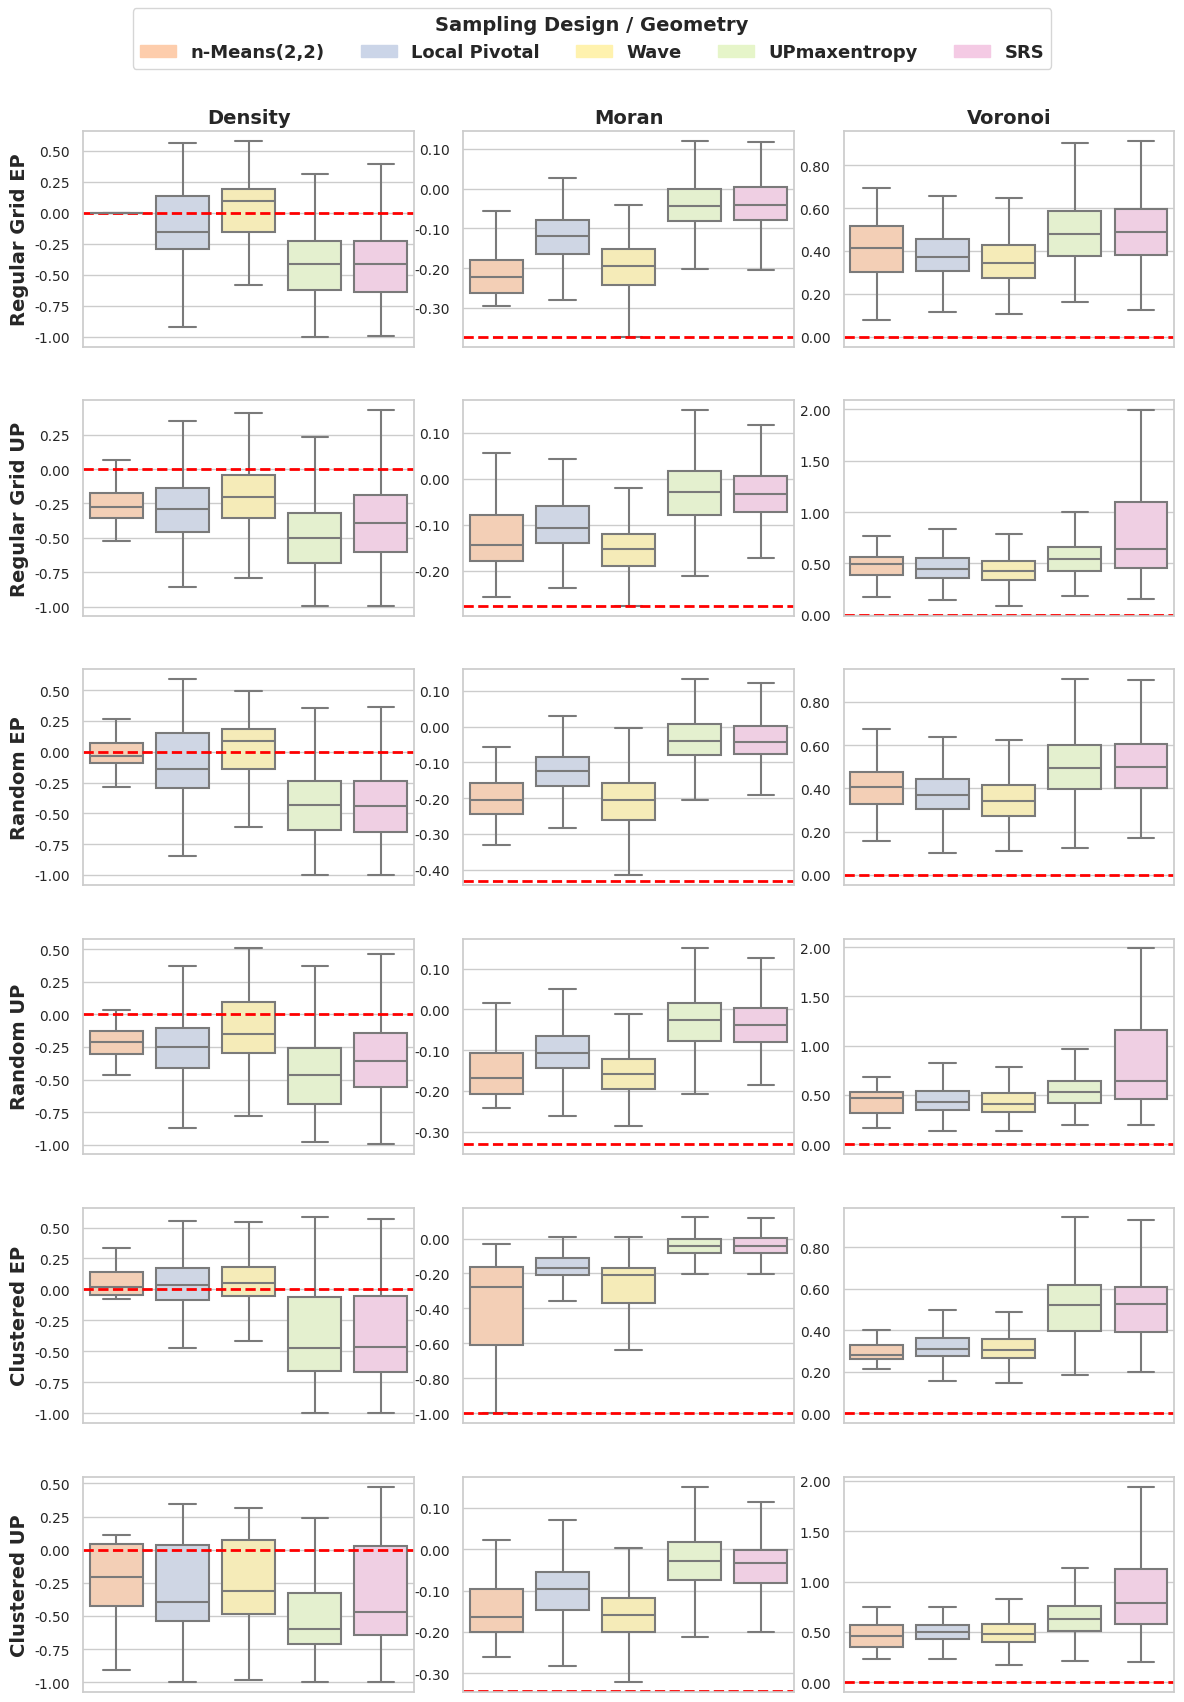

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

# Folder and file info
results_folder = '/home/divar/projects/geometric-sampling/data_samples/results'
result_files = [
    "cleaned_results_grid_eq.csv",
    "cleaned_results_grid_uneq.csv",
    "cleaned_results_random_eq.csv",
    "cleaned_results_random_uneq.csv",
    "cleaned_results_clust_eq.csv",
    "cleaned_results_clust_uneq.csv",
]

pretty_names = {
    "grid_eq": "Regular Grid EP",
    "grid_uneq": "Regular Grid UP",
    "random_eq": "Random EP",
    "random_uneq": "Random UP",
    "clust_eq": "Clustered EP",
    "clust_uneq": "Clustered UP",
}

# For display
pop_names = [s.replace("cleaned_results_", "").replace(".csv", "") for s in result_files]

# Mapping for all names (methods and shapes!)
method_name_mapping = {
    "K-Means (1, 1)": "n-Means",
    "K-Means (3, 3)": "n-Means(2,2)",
    "Local Pivotal": "Local Pivotal",
    "Random": "SRS",
    "UPmaxentropy": "UPmaxentropy",
    "wave": "Wave",
    "cube": "Cube"
}
# desired consistent plotting order
method_order = [
     "n-Means(2,2)", "Local Pivotal", "Wave", "UPmaxentropy", "SRS", 
]

# Read results into a dict, fix column names
results_dict = {}
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname), header=None)
    # Name columns the same way as in cleaning script
    df.columns = ["Method", "Density", "Moran", "Local Balanced"]
    # Map pretty method names (including shapes)
    df["Method"] = df["Method"].map(method_name_mapping)
    results_dict[name] = df

# All method labels present
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel2", n_colors=len(all_methods))))
# Metrics (ensure correct order: Density, Moran, Local Balanced)
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname), header=None)
    df.columns = ["Method", "Density", "Moran", "Local Balanced"]
    df.rename(columns={"Local Balanced": "Voronoi"}, inplace=True)
    df["Method"] = df["Method"].map(method_name_mapping)
    results_dict[name] = df

columns = ["Density", "Moran", "Voronoi"]
# Create 6 populations x 3 metrics grid
n_rows = len(pop_names)
n_cols = len(columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]
        sns.boxplot(
            x="Method",
            y=metric,
            data=df_pop[df_pop[metric].astype(float) < 2],  # filter big outliers if any
            hue="Method",
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5,
        )
        ax.tick_params(axis='x', length=0)
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=14)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        if not (row_idx == 0 and col_idx == 0):
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))  # 2 decimals
        if metric == "Moran":
            ax.axhline(y=min(df_pop['Moran']), color='red', linestyle='--', linewidth=2)
        else:
            ax.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Shared legend
from matplotlib.patches import Patch
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)
labels = [m for m in method_order if m in all_methods]
handles = [Patch(color=method_palette[m]) for m in labels]

leg = fig.legend(
    handles, labels, loc='upper center', ncol=len(method_order),
    title="Sampling Design / Geometry", fontsize=13, title_fontsize=14
)
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')

fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(wspace=0.15, hspace=0.25)
plt.show()